In [1]:
##                                                                                                                    GOOD

import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from citipy import citipy

pd.options.display.max_rows = 1000

ten_year_source = os.path.join('EF_Data_Sets', '2008-2019_combined.xls')
ten_year_df = pd.read_excel(ten_year_source)

current_year_source = os.path.join('EF_Data_Sets', 'index2019_data.xls')

mmxix = os.path.join('CIA_Info', '2019_CIA_factbook.json')
with open(mmxix, encoding = 'utf8') as jsonfile:
    cia_facts = json.load(jsonfile)

In [2]:
##                                                                                                                    GOOD

region_col = [1, 3]
region_df = pd.read_excel(current_year_source, usecols = region_col)
region_df.rename(columns = {"Country Name": "name", "Region": "region"}, inplace = True)

In [3]:
##                                                                                                                    GOOD

primary_df = pd.merge(ten_year_df, region_df,  how = 'outer', on = 'name')

In [4]:
##                                                                                                                    GOOD

# Slice 2019 from primary_df AS A COPY, as not to modify primary_df

df_2019 = primary_df[primary_df['index year'] == 2019].copy(deep = True)

# pull list of country names for data cleaning
series = df_2019['name']
country_names = []

for name in series:
    country_names.append(name)

# drop space from last character of name string
end_space_dropped = []

for name in country_names:
    if name[-1] == ' ':
        end_clean = name[:-1]
        end_space_dropped.append(end_clean)        
    else:
        end_space_dropped.append(name)                

In [5]:
##                                                                                                                    GOOD

# fill spaces and replace hyphens with '_'
search_country = []

for name in end_space_dropped:
    spacefill = name.replace(' ', '_')
    formatted = spacefill.replace('-', '_')
    if formatted[:4] == 'The_':
        cleaned = formatted[4:] + '_The'
        search_country.append(cleaned)
    elif 'Congo' in formatted:
        if 'Democratic' in formatted:
            cleaned = 'Congo_Democratic_Republic_of_The'
            search_country.append(cleaned)
        else:
            cleaned = 'Congo_Republic_of_The'
            search_country.append(cleaned)                  
    elif 'Korea' in formatted:
        if 'South' in formatted:
            cleaned = 'Korea_South'
            search_country.append(cleaned)
        else:
            cleaned = 'Korea_North'
            search_country.append(cleaned)
    elif 'CÃ´' in formatted:
        cleaned = "Cote_d'_Ivoire"
        search_country.append(cleaned)
    elif 'Kyrgyz' in formatted:
        cleaned = 'Kyrgyzstan'
        search_country.append(cleaned)
    elif 'SÃ£o' in formatted:
        cleaned = 'Sao_Tome_and_Principe'
        search_country.append(cleaned)
    elif 'Brunei' in formatted:
        cleaned = 'Brunei'
        search_country.append(cleaned)
    elif 'Czech' in formatted:
        cleaned = 'Czechia'
        search_country.append(cleaned)
    elif 'Macedonia' in formatted:
        cleaned = 'North_Macedonia'
        search_country.append(cleaned)
    elif 'Micronesia' in formatted:
        cleaned = 'Micronesia_Federated_States_of'
        search_country.append(cleaned)
    else:
        search_country.append(formatted)     

df_2019['search key'] = search_country

In [6]:
##                                                                                                                    GOOD

name = []
pop = []
gvt = []
gdpv = []
gdpy = []
gdpr = []
gdppc = []
gdppcMATH = []
gdppy = []
gdppr = []

for country in search_country: 
    try:
        access_country = cia_facts['countries'][country.lower()]
        name.append(country)

        population = access_country['data']['people']['population']['total']
        pop.append(population)

        form_of_government = access_country['data']['government']['government_type']

        if country == 'Malaysia':                                                   # delete if breaks   **
            gvt.append('federal parliamentary constitutional monarchy')             # delete if breaks   **
        elif 'Republic of Cyprus' in form_of_government:                            # if deleting above, chg to if
            gvt.append('presidential republic')                                     
        elif '(' in form_of_government:                                             
            break_one = form_of_government.split(sep = '(', maxsplit=2)             
            gvt.append(break_one[0])                                                
        elif ';' in form_of_government:                                             
            break_one = form_of_government.split(sep = ';', maxsplit=2)             
            gvt.append(break_one[0])                                                
        else:                                                                       
            gvt.append(form_of_government)                                          

        gdp_value = (int(access_country['data']['economy']['gdp']['purchasing_power_parity']['annual_values'][0]['value'])/
                    1000000000)
        gdpv.append(gdp_value)

        gdp_year = (access_country['data']['economy']['gdp']['purchasing_power_parity']['annual_values'][0]['date'])
        gdpy.append(gdp_year)      

        gdp_rank = access_country['data']['economy']['gdp']['purchasing_power_parity']['global_rank']    
        gdpr.append(gdp_rank)

        gdp_per_cap_round = (int(access_country['data']['economy']['gdp']['per_capita_purchasing_power_parity']
                                               ['annual_values'][0]['value']))
        gdppc.append(gdp_per_cap_round)

        gdp_per_cap_MATH = (gdp_value*1000000000)/population
        gdppcMATH.append(gdp_per_cap_MATH)        

        gdp_per_cap_year = (access_country['data']['economy']['gdp']['per_capita_purchasing_power_parity']
                                          ['annual_values'][0]['date'])
        gdppy.append(gdp_per_cap_year)

        gdp_per_cap_rank = access_country['data']['economy']['gdp']['per_capita_purchasing_power_parity']['global_rank']    
        gdppr.append(gdp_per_cap_rank)
        
    except KeyError:
        percapgdp = (gdp_value*1000000000)/population
        gdppc.append(percapgdp)
        gdppcMATH.append(percapgdp)        
        gdppy.append(gdp_year)
        gdppr.append('200')

In [7]:
##                                                                                                                    GOOD

cia_df = (pd.DataFrame(list(zip(name, pop, gvt, gdpv, gdpy, gdpr, gdppc, gdppy, gdppcMATH, gdppr)), 
          columns = ['search key', 'population', 'form of government', 'gdp (bil. usd)', 'gdp year', 'gdp rank', 
                     'per capita gdp (usd)', 'per capita gdp year', 'calculated per capita gdp (usd)', 'per capita rank']))

current_year_all_data_df = df_2019.merge(cia_df, how = 'outer', on = 'search key')
current_year_all_data_df.drop(columns=['search key'])

,name,index year,overall score,property rights,government integrity,judicial effectiveness,tax burden,government spending,fiscal health,business freedom,...,region,population,form of government,gdp (bil. usd),gdp year,gdp rank,per capita gdp (usd),per capita gdp year,calculated per capita gdp (usd),per capita rank
0,Afghanistan,2019.0,51.5,19.6,25.2,29.6,91.7,80.3,99.3,49.2,...,Asia-Pacific,34940837,presidential Islamic republic,69.450,2017,101,2000.000000,2017,1987.645574,209
1,Albania,2019.0,66.5,54.8,40.4,30.6,86.3,73.9,80.6,69.3,...,Europe,3057220,parliamentary republic,36.010,2017,125,12500.000000,2017,11778.674744,125
2,Algeria,2019.0,46.2,31.6,28.9,36.2,76.4,48.7,18.7,61.6,...,Middle East and North Africa,41657488,presidential republic,630.000,2017,36,15200.000000,2017,15123.331488,109
3,Angola,2019.0,50.6,35.9,20.5,26.6,83.9,80.7,58.2,55.7,...,Sub-Saharan Africa,30355880,presidential republic,193.600,2017,65,6800.000000,2017,6377.677076,160
4,Argentina,2019.0,52.2,47.8,33.5,44.5,69.3,49.5,33.0,56.4,...,Americas,44694198,presidential republic,922.100,2017,28,20900.000000,2017,20631.313264,88
5,Armenia,2019.0,67.7,57.2,38.6,46.3,84.7,79.0,53.0,78.3,...,Europe,3038217,parliamentary democracy,28.340,2017,136,9500.000000,2017,9327.839322,142
6,Australia,2019.0,80.9,79.1,79.9,86.5,62.8,60.1,86.2,88.3,...,Asia-Pacific,23470145,parliamentary democracy,1248.000,2017,19,50400.000000,2017,53173.936505,29
7,Austria,2019.0,72.0,84.2,77.4,71.3,50.5,24.5,85.5,74.9,...,Europe,8793370,federal parliamentary republic,441.000,2017,45,50000.000000,2017,50151.420900,31
8,Azerbaijan,2019.0,65.4,59.1,44.7,53.1,87.5,59.5,89.4,69.5,...,Asia-Pacific,10046516,presidential republic,172.200,2017,73,17500.000000,2017,17140.270319,100
9,Bahrain,2019.0,66.4,63.5,53.6,50.7,99.7,62.7,3.7,71.4,...,Middle East and North Africa,1442659,constitutional monarchy,71.170,2017,100,49000.000000,2017,49332.517248,33


In [8]:
## TOP 5 EFI COUNTRIES 2019
china_df = current_year_all_data_df[current_year_all_data_df['name'] == 'China']
us_df = current_year_all_data_df[current_year_all_data_df['name'] == 'United States']
india_df = current_year_all_data_df[current_year_all_data_df['name'] == 'India']
japan_df = current_year_all_data_df[current_year_all_data_df['name'] == 'Japan']
germany_df = current_year_all_data_df[current_year_all_data_df['name'] == 'Germany']

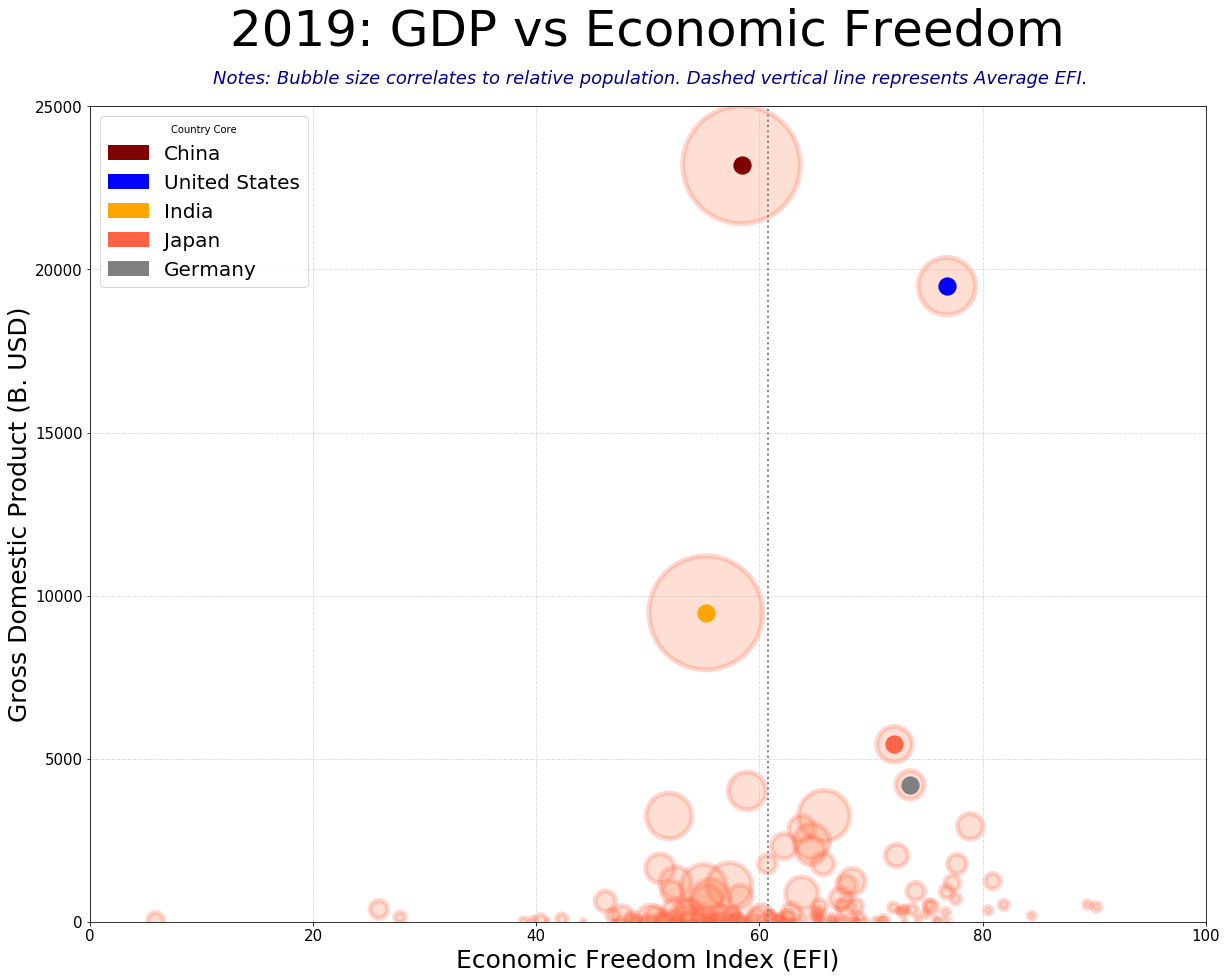

In [9]:
# SCATTER: GDP v EFI

plt.figure(figsize = (20, 15))

# Title the plot.
plt.title('2019: GDP vs Economic Freedom\n', fontsize = 50)

# Label and limits for x-axis.
plt.xlabel('Economic Freedom Index (EFI)', fontsize = 25)
plt.xlim (0, 100)
plt.xticks (fontsize = 15)

# Label and limits for y-axis.
plt.ylabel('Gross Domestic Product (B. USD)', fontsize = 25)
plt.ylim (0, 25000)
plt.yticks (fontsize = 15)

# Add light grid and vert line to represent mean EF score
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axvline(current_year_all_data_df['overall score'].mean(), lw = 2, ls = ':', c = 'grey') 

# PLOT DATA
plt.scatter(current_year_all_data_df['overall score'], current_year_all_data_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'coral', 
            edgecolor = 'tomato', 
            alpha = 0.25, 
            s = current_year_all_data_df['population']/100000, 
            linewidths = 5.0)

plt.scatter(china_df['overall score'], china_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'maroon', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(us_df['overall score'], us_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'blue', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(india_df['overall score'], india_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'orange', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(japan_df['overall score'], japan_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'tomato', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(germany_df['overall score'], germany_df['gdp (bil. usd)'], 
            marker = 'o', 
            c = 'grey', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)


# Comment on bubble size and vert line.
bubble_size = ('Notes: Bubble size correlates to relative population. Dashed vertical line represents Average EFI.')
plt.text(11, 25700, bubble_size, fontsize = 18, color = 'darkblue', style = 'italic', wrap = True)

# Add legend.
us_patch = mpatches.Patch(color='blue', label='United States')
china_patch = mpatches.Patch(color='maroon', label='China')
india_patch = mpatches.Patch(color='orange', label='India')
japan_patch = mpatches.Patch(color='tomato', label='Japan')
germany_patch = mpatches.Patch(color='grey', label='Germany')

(plt.legend(title='Country Core', 
            handles=[china_patch, us_patch, india_patch, japan_patch, germany_patch], 
            fontsize = 20, 
            loc='upper left'))

plt.savefig((f'PLOT - GDPvEconFreedom.png'))
plt.show()

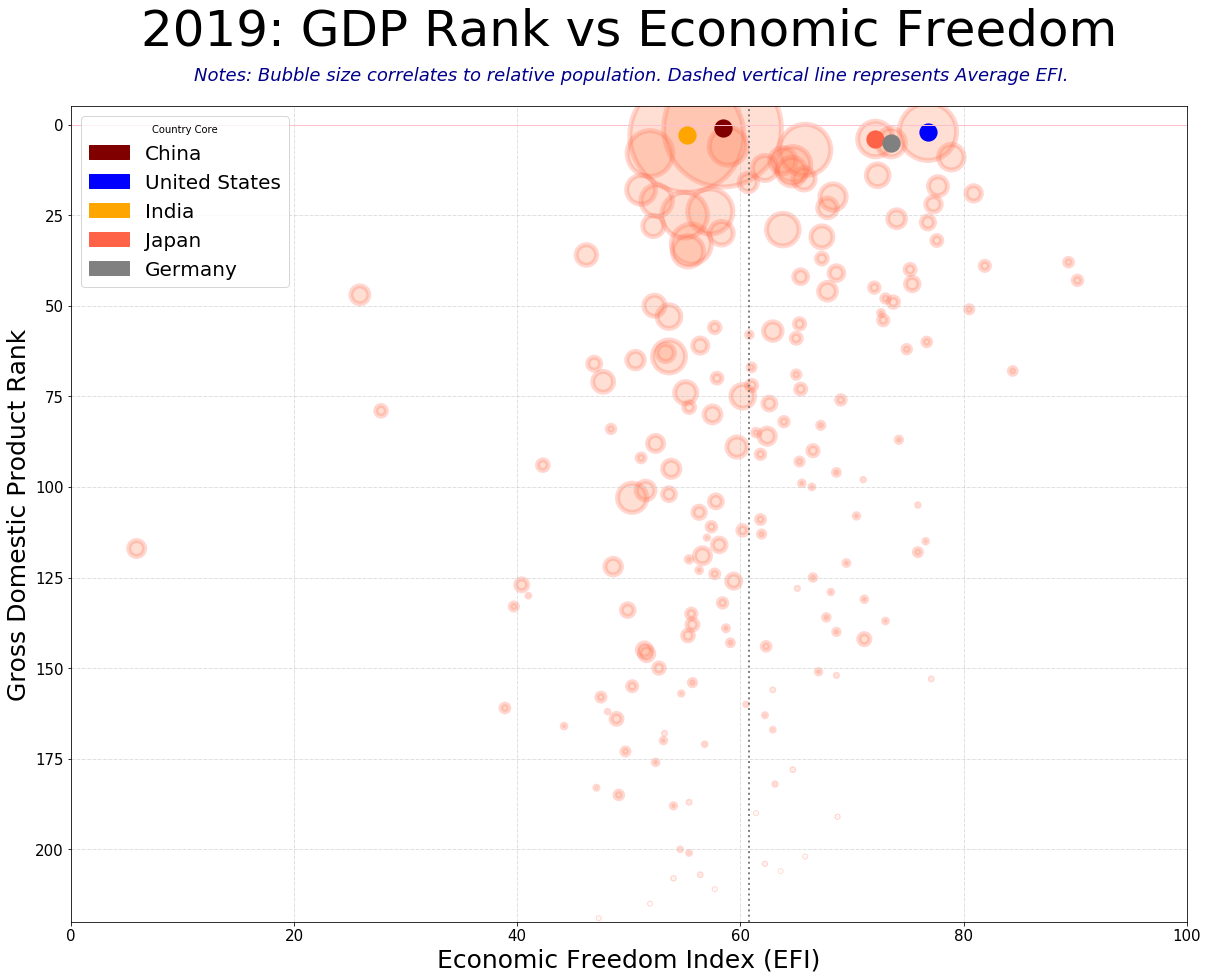

In [10]:
# SCATTER: GDP RANK v EFI

plt.figure(figsize = (20, 15))

# Title the plot.
plt.title('2019: GDP Rank vs Economic Freedom\n', fontsize = 50)

# Label and limits for x-axis.
plt.xlabel('Economic Freedom Index (EFI)', fontsize = 25)
plt.xlim (0, 100)
plt.xticks (fontsize = 15)

# Label and limits for y-axis.
plt.ylabel('Gross Domestic Product Rank', fontsize = 25)
plt.ylim (220, -5)
plt.yticks (fontsize = 15)

# Add light grid and vert line to represent mean EF score
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axvline(current_year_all_data_df['overall score'].mean(), lw = 2, ls = ':', c = 'grey') 
plt.axhline(0, lw = 1, c = 'pink') 


# PLOT DATA
plt.scatter(current_year_all_data_df['overall score'], current_year_all_data_df['gdp rank'], 
            marker = 'o', 
            c = 'coral', 
            edgecolor = 'tomato', 
            alpha = 0.25, 
            s = current_year_all_data_df['population']/100000, 
            linewidths = 5.0)

plt.scatter(china_df['overall score'], china_df['gdp rank'], 
            marker = 'o', 
            c = 'maroon', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(us_df['overall score'], us_df['gdp rank'], 
            marker = 'o', 
            c = 'blue', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(india_df['overall score'], india_df['gdp rank'], 
            marker = 'o', 
            c = 'orange', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(japan_df['overall score'], japan_df['gdp rank'], 
            marker = 'o', 
            c = 'tomato', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(germany_df['overall score'], germany_df['gdp rank'], 
            marker = 'o', 
            c = 'grey', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)


# Comment on bubble size and vert line.
bubble_size = ('Notes: Bubble size correlates to relative population. Dashed vertical line represents Average EFI.')
plt.text(11, -12, bubble_size, fontsize = 18, color = 'darkblue', style = 'italic', wrap = True)

# Add legend.
us_patch = mpatches.Patch(color='blue', label='United States')
china_patch = mpatches.Patch(color='maroon', label='China')
india_patch = mpatches.Patch(color='orange', label='India')
japan_patch = mpatches.Patch(color='tomato', label='Japan')
germany_patch = mpatches.Patch(color='grey', label='Germany')

(plt.legend(title='Country Core', 
            handles=[china_patch, us_patch, india_patch, japan_patch, germany_patch], 
            fontsize = 20, 
            loc='upper left'))

plt.savefig((f'PLOT - GDPRankvEconFreedom.png'))
plt.show()

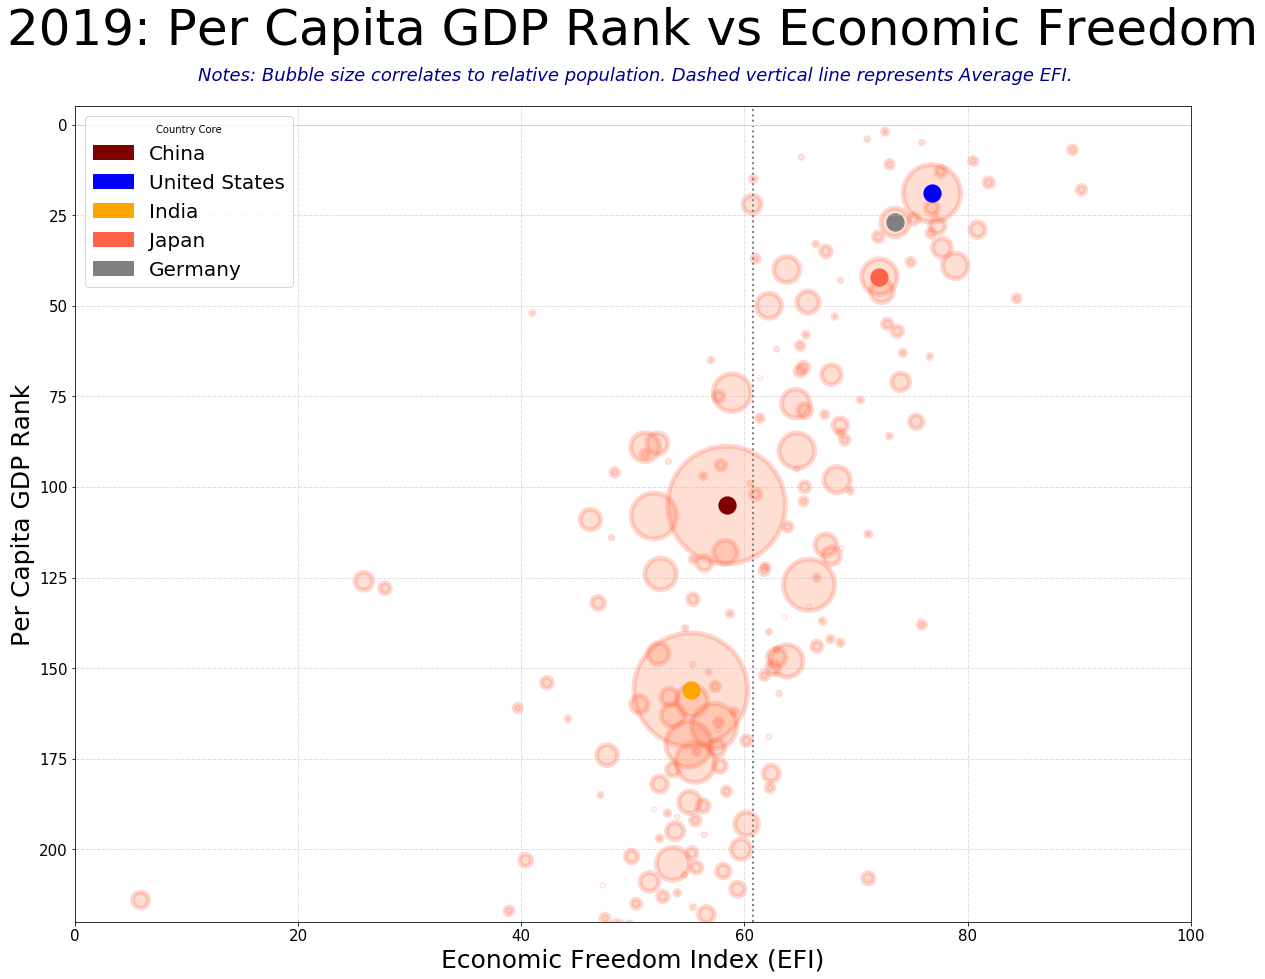

In [11]:
# SCATTER: GDP PER CAPITA RANK v EFI

plt.figure(figsize = (20, 15))

# Title the plot.
plt.title('2019: Per Capita GDP Rank vs Economic Freedom\n', fontsize = 50)

# Label and limits for x-axis.
plt.xlabel('Economic Freedom Index (EFI)', fontsize = 25)
plt.xlim (0, 100)
plt.xticks (fontsize = 15)

# Label and limits for y-axis.
plt.ylabel('Per Capita GDP Rank', fontsize = 25)
plt.ylim (220, -5)
plt.yticks (fontsize = 15)

# Add light grid and vert line to represent mean EF score
plt.grid(color = 'silver', linestyle = '-.', linewidth = 0.5)
plt.axvline(current_year_all_data_df['overall score'].mean(), lw = 2, ls = ':', c = 'grey') 
plt.axhline(0, lw = 1, c = 'pink') 


# PLOT DATA
plt.scatter(current_year_all_data_df['overall score'], current_year_all_data_df['per capita rank'], 
            marker = 'o', 
            c = 'coral', 
            edgecolor = 'tomato', 
            alpha = 0.25, 
            s = current_year_all_data_df['population']/100000, 
            linewidths = 5.0)

plt.scatter(china_df['overall score'], china_df['per capita rank'], 
            marker = 'o', 
            c = 'maroon', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(us_df['overall score'], us_df['per capita rank'], 
            marker = 'o', 
            c = 'blue', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(india_df['overall score'], india_df['per capita rank'], 
            marker = 'o', 
            c = 'orange', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(japan_df['overall score'], japan_df['per capita rank'], 
            marker = 'o', 
            c = 'tomato', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)

plt.scatter(germany_df['overall score'], germany_df['per capita rank'], 
            marker = 'o', 
            c = 'grey', 
            alpha = 1, 
            s = 175, 
            linewidths = 5.0)


# Comment on bubble size and vert line.
bubble_size = ('Notes: Bubble size correlates to relative population. Dashed vertical line represents Average EFI.')
plt.text(11, -12, bubble_size, fontsize = 18, color = 'darkblue', style = 'italic', wrap = True)

# Add legend.
us_patch = mpatches.Patch(color='blue', label='United States')
china_patch = mpatches.Patch(color='maroon', label='China')
india_patch = mpatches.Patch(color='orange', label='India')
japan_patch = mpatches.Patch(color='tomato', label='Japan')
germany_patch = mpatches.Patch(color='grey', label='Germany')

(plt.legend(title='Country Core', 
            handles=[china_patch, us_patch, india_patch, japan_patch, germany_patch], 
            fontsize = 20, 
            loc='upper left'))

plt.savefig((f'PLOT - PerCapGDPvEconFreedom.png'))
plt.show()